<a href="https://colab.research.google.com/github/vkmanojk/COVID19/blob/master/Covid_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19: Time Series Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Import Statements

In [2]:
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

%tensorflow_version 1.x
import torch
from torch import nn, optim
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras import losses
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import tensorflow as tf
from tensorflow import set_random_seed
from numpy.random import seed

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
print(tf.__version__)

1.15.2


In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
set_random_seed(1)
seed(1)
torch.manual_seed(1)

## Loading the data

In [5]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/Dataset/newdata.csv', parse_dates=['Date'])
df.head()

,Unnamed: 0,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.0,0.0,0.0
1,1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.0,0.0,0.0
2,2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.0,0.0,0.0
3,3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.0,0.0,0.0
4,4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.0,0.0,0.0


## Data Preprocessing

In [6]:
df['Recovered'].fillna(0,inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.0,0.0,0.0
1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.0,0.0,0.0
2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.0,0.0,0.0
3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.0,0.0,0.0
4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.0,0.0,0.0


In [0]:
scaler = MinMaxScaler()
df[['Confirmed', 'Deaths', 'Recovered']] = scaler.fit_transform((df[['Confirmed', 'Deaths', 'Recovered']]))

In [0]:
train_date = []
test_date = []
t = pd.Timestamp(year=2020,month=3,day=3)

for i in range(len(df['Date'])):    
#     print((pd.Timestamp(df.iloc[i,4]) - t).days)
    if (pd.Timestamp(df.iloc[i,4]) - t).days >=0:
#         print(df.iloc[i,4])
        train_date.append(df.iloc[i,4])
    else:
#         print(df.iloc[i,4])
        test_date.append(df.iloc[i,4])

In [9]:
test = {'Province/State':[],
         'Country':[],
         'latitude':[],
         'longitude':[],
         'Date':[],
         'loc_id':[],
         'Key':[],
         'Confirmed':[],
         'Deaths':[],
         'Recovered':[]}
for i in range(len(df)):
    if df.iloc[i,4] in train_date:
        test['Province/State'].append(df.iloc[i,0])
        test['Country'].append(df.iloc[i,1])
        test['latitude'].append(df.iloc[i,2])
        test['longitude'].append(df.iloc[i,3])
        test['Date'].append(df.iloc[i,4])
        test['loc_id'].append(df.iloc[i,5])
        test['Key'].append(df.iloc[i,6])
        test['Confirmed'].append(df.iloc[i,7])
        test['Deaths'].append(df.iloc[i,8])
        test['Recovered'].append(df.iloc[i,9])

test = pd.DataFrame(test)
test.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-03-03,0,41,0.000498,0.003676,0.009469
1,Not specified,Afghanistan,33.0,65.0,2020-03-04,0,42,0.000498,0.003676,0.009469
2,Not specified,Afghanistan,33.0,65.0,2020-03-05,0,43,0.000498,0.003676,0.009469
3,Not specified,Afghanistan,33.0,65.0,2020-03-06,0,44,0.000498,0.003676,0.009469
4,Not specified,Afghanistan,33.0,65.0,2020-03-07,0,45,0.000498,0.003676,0.009469


In [10]:
train = {'Province/State':[],
         'Country':[],
         'latitude':[],
         'longitude':[],
         'Date':[],
         'loc_id':[],
         'Key':[],
         'Confirmed':[],
         'Deaths':[],
         'Recovered':[]}
for i in range(len(df)):
    if df.iloc[i,4] in test_date:
        train['Province/State'].append(df.iloc[i,0])
        train['Country'].append(df.iloc[i,1])
        train['latitude'].append(df.iloc[i,2])
        train['longitude'].append(df.iloc[i,3])
        train['Date'].append(df.iloc[i,4])
        train['loc_id'].append(df.iloc[i,5])
        train['Key'].append(df.iloc[i,6])
        train['Confirmed'].append(df.iloc[i,7])
        train['Deaths'].append(df.iloc[i,8])
        train['Recovered'].append(df.iloc[i,9])

train = pd.DataFrame(train)
train.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.000498,0.003676,0.009469
1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.000498,0.003676,0.009469
2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.000498,0.003676,0.009469
3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.000498,0.003676,0.009469
4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.000498,0.003676,0.009469


In [11]:
print('No. of rows in train and test:',train.shape[0], test.shape[0])

No. of rows in train and test: 10578 7998


In [12]:
print('Min date from train set: %s' % train['Date'].min().date())
print('Max date from train set: %s' % train['Date'].max().date())

Min date from train set: 2020-01-22
Max date from train set: 2020-03-02


In [13]:
lag_size = (test['Date'].max().date() - train['Date'].max().date()).days
print('Max date from train set: %s' % train['Date'].max().date())
print('Max date from test set: %s' % test['Date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2020-03-02
Max date from test set: 2020-04-02
Forecast lag size 31


In [0]:
daily_confirmed = train.groupby('Date', as_index=False)['Confirmed'].sum()
country_confirmed = train.groupby(['Country', 'Date'], as_index=False)['Confirmed'].sum()

daily_death = train.groupby('Date', as_index=False)['Deaths'].sum()
country_death = train.groupby(['Country', 'Date'], as_index=False)['Deaths'].sum()

daily_recovered = train.groupby('Date', as_index=False)['Recovered'].sum()
country_recovered = train.groupby(['Country', 'Date'], as_index=False)['Recovered'].sum()

In [18]:
train_gp = train.sort_values('Date').groupby(['Country', 'Date'], as_index=False)
train_gp = train_gp.agg({'Confirmed':['sum'],'Deaths':['sum'],'Recovered':['sum']})
train_gp.columns = ['Country', 'Date', 'Confirmed','Deaths','Recovered']
train_gp.head()
le = LabelEncoder()
train_gp['Country'] = le.fit_transform(train_gp['Country'])
train_gp.head()

,Country,Date,Confirmed,Deaths,Recovered
0,0,2020-01-22,0.000498,0.003676,0.009469
1,0,2020-01-23,0.000498,0.003676,0.009469
2,0,2020-01-24,0.000498,0.003676,0.009469
3,0,2020-01-25,0.000498,0.003676,0.009469
4,0,2020-01-26,0.000498,0.003676,0.009469


In [0]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()

    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
window = 30
lag = lag_size
series = series_to_supervised(train_gp.drop('Date', axis=1), window=window, lag=lag)
series.head()

,Country(t-30),Confirmed(t-30),Deaths(t-30),Recovered(t-30),Country(t-29),Confirmed(t-29),Deaths(t-29),Recovered(t-29),Country(t-28),Confirmed(t-28),Deaths(t-28),Recovered(t-28),Country(t-27),Confirmed(t-27),Deaths(t-27),Recovered(t-27),Country(t-26),Confirmed(t-26),Deaths(t-26),Recovered(t-26),Country(t-25),Confirmed(t-25),Deaths(t-25),Recovered(t-25),Country(t-24),Confirmed(t-24),Deaths(t-24),Recovered(t-24),Country(t-23),Confirmed(t-23),Deaths(t-23),Recovered(t-23),Country(t-22),Confirmed(t-22),Deaths(t-22),Recovered(t-22),Country(t-21),Confirmed(t-21),Deaths(t-21),Recovered(t-21),...,Country(t-8),Confirmed(t-8),Deaths(t-8),Recovered(t-8),Country(t-7),Confirmed(t-7),Deaths(t-7),Recovered(t-7),Country(t-6),Confirmed(t-6),Deaths(t-6),Recovered(t-6),Country(t-5),Confirmed(t-5),Deaths(t-5),Recovered(t-5),Country(t-4),Confirmed(t-4),Deaths(t-4),Recovered(t-4),Country(t-3),Confirmed(t-3),Deaths(t-3),Recovered(t-3),Country(t-2),Confirmed(t-2),Deaths(t-2),Recovered(t-2),Country(t-1),Confirmed(t-1),Deaths(t-1),Recovered(t-1),Country(t),Confirmed(t),Deaths(t),Recovered(t),Country(t+31),Confirmed(t+31),Deaths(t+31),Recovered(t+31)
30,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
31,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
32,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000498,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
33,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0,0.000532,0.003676,0.009469,1.0,0.000498,0.003676,0.009469
34,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,0.0,0.000498,0.003676,0.009469,...,0.0,0.000498,0.003676,0.009469,0.0,0.00049

In [0]:
last_country = 'Country(t-%d)' % window
series = series[(series['Country(t)'] == series[last_country])]

In [0]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Recovered','Deaths']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Deaths','Recovered']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['Recovered(t)'], axis=1, inplace=True)
series.drop(['Deaths(t)'],axis = 1, inplace=True)

In [23]:
series.head()

,Country(t-30),Confirmed(t-30),Country(t-29),Confirmed(t-29),Country(t-28),Confirmed(t-28),Country(t-27),Confirmed(t-27),Country(t-26),Confirmed(t-26),Country(t-25),Confirmed(t-25),Country(t-24),Confirmed(t-24),Country(t-23),Confirmed(t-23),Country(t-22),Confirmed(t-22),Country(t-21),Confirmed(t-21),Country(t-20),Confirmed(t-20),Country(t-19),Confirmed(t-19),Country(t-18),Confirmed(t-18),Country(t-17),Confirmed(t-17),Country(t-16),Confirmed(t-16),Country(t-15),Confirmed(t-15),Country(t-14),Confirmed(t-14),Country(t-13),Confirmed(t-13),Country(t-12),Confirmed(t-12),Country(t-11),Confirmed(t-11),Country(t-10),Confirmed(t-10),Country(t-9),Confirmed(t-9),Country(t-8),Confirmed(t-8),Country(t-7),Confirmed(t-7),Country(t-6),Confirmed(t-6),Country(t-5),Confirmed(t-5),Country(t-4),Confirmed(t-4),Country(t-3),Confirmed(t-3),Country(t-2),Confirmed(t-2),Country(t-1),Confirmed(t-1),Country(t),Confirmed(t),Country(t+31),Confirmed(t+31)
30,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
31,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
32,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000498,1.0,0.000498
33,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0,0.000532,1.0,0.000498
34,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000498,0.0,0.000532,0,0.000498,1.0,0.000498


In [0]:
labels_col = 'Confirmed(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
# series = series.drop(columns = ['Recovered(t+%d)' % lag_size,'Deaths(t+%d)' % lag_size])

In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (1584, 63)
Validation set shape (396, 63)


In [0]:
# columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Reco']]
# for i in range(window, 0, -1):
#     columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Country']]
# series.drop(columns_to_drop, axis=1, inplace=True)
# series.drop(['Country(t)'], axis=1, inplace=True)

In [27]:
train.head()

,Province/State,Country,latitude,longitude,Date,loc_id,Key,Confirmed,Deaths,Recovered
0,Not specified,Afghanistan,33.0,65.0,2020-01-22,0,0,0.000498,0.003676,0.009469
1,Not specified,Afghanistan,33.0,65.0,2020-01-23,0,1,0.000498,0.003676,0.009469
2,Not specified,Afghanistan,33.0,65.0,2020-01-24,0,2,0.000498,0.003676,0.009469
3,Not specified,Afghanistan,33.0,65.0,2020-01-25,0,3,0.000498,0.003676,0.009469
4,Not specified,Afghanistan,33.0,65.0,2020-01-26,0,4,0.000498,0.003676,0.009469


In [0]:
train = train.groupby('Date').sum()
train = train.drop(columns=['latitude','longitude','loc_id','Key'],axis=1)

In [0]:
test = test.groupby('Date').sum()
test = test.drop(columns=['latitude','longitude','loc_id','Key'])

In [0]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(np.array(x))
        ys.append(np.array(y))
#     print('X',xs)
#     print('Y',ys)
    return np.array(xs), np.array(ys)

In [31]:
df = df.groupby('Date').sum()
df = df.drop(columns=['latitude','longitude','loc_id','Key','Deaths','Recovered'],axis=1)
df.head()

,Confirmed
Date,
2020-01-22,0.147030
2020-01-23,0.131878
2020-01-24,0.138125
2020-01-25,0.144969
2020-01-26,0.151316


In [32]:
split_point = int(len(df) * 0.80)
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header = False)
validation.to_csv('validation.csv', header = False)

Dataset 57, Validation 15


In [0]:
arima_series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
arima_X_train = arima_series.values
arima_X_train = arima_X_train.astype('float32')

arima_valid = pd.read_csv('validation.csv',header=None, index_col=0, parse_dates=True, squeeze=True)
arima_X_valid = arima_valid.values
arima_X_valid = arima_X_valid.astype('float32')

In [0]:
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return pd.Series(diff)

In [35]:
stationary = difference(arima_X_train)
stationary.index = arima_series.index[1:]
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
stationary.to_csv('train_stationary.csv', header = False)

ADF Statistic: -8.180516
p-value: 0.000000
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596


## Model Building

### Multilayer Perceptron Model

In [0]:
epochs = 20
batch = 4
lr = 0.0003
adam = optimizers.Adam(lr)

In [37]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(128,activation = 'relu'))
model_mlp.add(Dense(256,activation = 'relu'))
model_mlp.add(Dense(512,activation = 'relu'))
model_mlp.add(Dense(1024,activation = 'relu'))
model_mlp.add(Dense(512,activation = 'relu'))
model_mlp.add(Dense(256,activation = 'relu'))
model_mlp.add(Dense(128,activation = 'relu'))
model_mlp.add(Dense(64,activation = 'relu'))
model_mlp.add(Dropout(lr*10))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    


In [38]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=1)




Train on 1584 samples, validate on 396 samples
Epoch 1/20





1584/1584 [==============================] - 2s 2ms/step - loss: 0.4811 - val_loss: 0.0160
Epoch 2/20
1584/1584 [==============================] - 1s 928us/step - loss: 0.0359 - val_loss: 0.0187
Epoch 3/20
1584/1584 [==============================] - 1s 939us/step - loss: 0.0208 - val_loss: 0.0167
Epoch 4/20
1584/1584 [==============================] - 1s 924us/step - loss: 0.0115 - val_loss: 0.0036
Epoch 5/20
1584/1584 [==============================] - 1s 912us/step - loss: 0.0058 - val_loss: 6.6819e-05
Epoch 6/20
1584/1584 [==============================] - 1s 941us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 7/20
1584/1584 [==============================] - 1s 924us/step - loss: 0.0031 - val_loss: 0.0058
Epoch 8/20
1584/1584 [==============================] - 1s 928us/step - loss: 0.0050 - val_loss: 2.2474e-04
Epoch 9/20
1584/1584 [==============================] - 1s 914us/step - loss: 0.0018 - val_loss: 3.9997e-04

### Convolutional Neural Network

In [39]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1584, 63, 1)
Validation set shape (396, 63, 1)


In [42]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(64, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(lr * 10))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 61, 64)            256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 28, 128)           24704     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 14, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 12, 128)           49280     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 128)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4, 64)            

In [43]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)

Train on 1584 samples, validate on 396 samples
Epoch 1/20
1584/1584 [==============================] - 2s 1ms/step - loss: 0.0501 - val_loss: 1.5160e-04
Epoch 2/20
1584/1584 [==============================] - 1s 489us/step - loss: 0.0013 - val_loss: 7.9044e-04
Epoch 3/20
1584/1584 [==============================] - 1s 519us/step - loss: 0.0012 - val_loss: 3.8535e-04
Epoch 4/20
1584/1584 [==============================] - 1s 508us/step - loss: 5.5695e-04 - val_loss: 4.1141e-05
Epoch 5/20
1584/1584 [==============================] - 1s 514us/step - loss: 7.4671e-04 - val_loss: 1.5161e-04
Epoch 6/20
1584/1584 [==============================] - 1s 516us/step - loss: 4.4990e-04 - val_loss: 4.4673e-05
Epoch 7/20
1584/1584 [==============================] - 1s 522us/step - loss: 4.7004e-04 - val_loss: 5.8877e-05
Epoch 8/20
1584/1584 [==============================] - 1s 508us/step - loss: 4.2758e-04 - val_loss: 3.9883e-05
Epoch 9/20
1584/1584 [==============================] - 1s 505us/step -

### Long Short-Term Memory

In [46]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True,activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(lr*10))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 63, 64)            16896     
_________________________________________________________________
lstm_11 (LSTM)               (None, 63, 128)           98816     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 165,185
Trainable params: 165,185
Non-trainable params: 0
_________________________________________________________________


In [47]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)

Train on 1584 samples, validate on 396 samples
Epoch 1/20
1584/1584 [==============================] - 13s 8ms/step - loss: 0.0071 - val_loss: 5.1676e-04
Epoch 2/20
1584/1584 [==============================] - 10s 6ms/step - loss: 7.6424e-04 - val_loss: 3.8255e-04
Epoch 3/20
1584/1584 [==============================] - 10s 6ms/step - loss: 7.8961e-04 - val_loss: 4.3942e-04
Epoch 4/20
1584/1584 [==============================] - 10s 6ms/step - loss: 6.0853e-04 - val_loss: 3.1607e-04
Epoch 5/20
1584/1584 [==============================] - 10s 6ms/step - loss: 5.0913e-04 - val_loss: 1.7010e-04
Epoch 6/20
1584/1584 [==============================] - 10s 6ms/step - loss: 7.9370e-04 - val_loss: 2.3735e-04
Epoch 7/20
1584/1584 [==============================] - 10s 6ms/step - loss: 5.6420e-04 - val_loss: 1.6371e-04
Epoch 8/20
1584/1584 [==============================] - 10s 6ms/step - loss: 4.6341e-04 - val_loss: 2.1835e-04
Epoch 9/20
1584/1584 [==============================] - 10s 6ms/step 

### CNN-LSTM Hybrid Model

In [48]:
subsequences = 3
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1584, 3, 21, 1)
Validation set shape (396, 3, 21, 1)


In [49]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu', return_sequences=True))
model_cnn_lstm.add(LSTM(128, activation='relu',return_sequences=True))
model_cnn_lstm.add(LSTM(64,activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)
model_cnn_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 21, 64)      128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10, 128)     8320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 5, 128)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 5, 64)       8256      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 128)        

In [50]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1)

Train on 1584 samples, validate on 396 samples
Epoch 1/20
1584/1584 [==============================] - 6s 4ms/step - loss: 0.0018 - val_loss: 4.4169e-05
Epoch 2/20
1584/1584 [==============================] - 1s 804us/step - loss: 2.1592e-04 - val_loss: 4.6493e-05
Epoch 3/20
1584/1584 [==============================] - 1s 824us/step - loss: 2.2118e-04 - val_loss: 3.9258e-05
Epoch 4/20
1584/1584 [==============================] - 1s 848us/step - loss: 2.1652e-04 - val_loss: 3.8514e-05
Epoch 5/20
1584/1584 [==============================] - 1s 837us/step - loss: 2.1560e-04 - val_loss: 3.7564e-05
Epoch 6/20
1584/1584 [==============================] - 1s 855us/step - loss: 2.1796e-04 - val_loss: 4.1217e-05
Epoch 7/20
1584/1584 [==============================] - 1s 815us/step - loss: 2.1653e-04 - val_loss: 4.0160e-05
Epoch 8/20
1584/1584 [==============================] - 1s 837us/step - loss: 2.1448e-04 - val_loss: 4.0843e-05
Epoch 9/20
1584/1584 [==============================] - 1s 804u

### PyTorch

In [51]:
seq_length = 5
X_train_torch, y_train_torch = create_sequences(train.drop(columns=['Recovered','Deaths']), seq_length)
X_valid_torch, y_valid_torch = create_sequences(test.drop(columns=['Recovered','Deaths']), seq_length)

X_train_torch = torch.from_numpy(X_train_torch).float()
y_train_torch = torch.from_numpy(y_train_torch).float()

X_valid_torch = torch.from_numpy(X_valid_torch).float()
y_valid_torch = torch.from_numpy(y_valid_torch).float()

print('Train set shape', X_train_torch.shape)
print('Validation set shape', X_valid_torch.shape)

Train set shape torch.Size([35, 5, 1])
Validation set shape torch.Size([25, 5, 1])


In [0]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout= lr * 10
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [0]:
def train_model(model,train_data,train_labels,test_data=None,test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = epochs
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(1,num_epochs+1):
        model.reset_hidden_state()
        y_pred = model(X_train_torch)
        loss = loss_fn(y_pred.float(), y_train_torch)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_valid_torch)
                test_loss = loss_fn(y_test_pred.float(), y_valid_torch)
                test_hist[t-1] = test_loss.item()

            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t-1] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return model.eval(), train_hist, test_hist, y_pred, y_test_pred

In [54]:
torch_model = CoronaVirusPredictor( n_features=1,n_hidden=128,seq_len=seq_length,n_layers=4)
print(torch_model)
torch_model, train_hist, test_hist, y_pred, y_test_pred = train_model( torch_model, X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)

CoronaVirusPredictor(
  (lstm): LSTM(1, 128, num_layers=4, dropout=0.0029999999999999996)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch 10 train loss: 0.25659266114234924 test loss: 42.7035026550293
Epoch 20 train loss: 0.25160136818885803 test loss: 41.91297149658203


### ARIMA

In [0]:
def predict_arima_model(X_train, X_valid, arima_order):
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    train_size = int(len(X_train) * 0.8)
    train, test = X_train[0:train_size], X_train[train_size:]
    history = [x for x in train]

    train_pred = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        train_pred.append(yhat)
        history.append(test[t])
    loss = losses.mean_squared_error(test, train_pred)
    loss = tf.Session().run(loss)
    sum = 0
    for i in loss:
      sum += i
    train_loss = sum / len(loss)

    valid_pred = []
    for t in range(len(X_valid)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        valid_pred.append(yhat)
        history.append(X_valid[t])
    loss = losses.mean_squared_error(X_valid, train_pred)
    loss = tf.Session().run(loss)
    sum = 0
    for i in loss:
      sum += i
    valid_loss = sum / len(loss)
    return train_loss,valid_loss, train_pred, valid_pred 

In [0]:
def evaluate_models(dataset, valid,  p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    valid = valid.astype('float32')
    best_train_score, best_valid_score, best_cfg = float("inf"),float("inf"), None
    train_losses = []
    valid_losses = []
    train_prediction = []
    valid_prediction = []
    i = 1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                  train_loss, valid_loss, train_pred, valid_pred = predict_arima_model(dataset,valid, order)
                  train_losses.append(train_loss)
                  valid_losses.append(valid_loss)
                  if (train_loss + valid_loss) < (best_train_score + best_valid_score):
                    best_train_score,best_valid_score, best_cfg = train_loss, valid_loss, order
                    train_prediction = train_pred
                    valid_prediction = valid_pred
                  print('ARIMA %s : Iteration = %s Train Loss=%.3f Valid Loss=%.3f' % (order,i,train_loss, valid_loss))
                except:
                  # print('ARIMA %s : Iteration = %s Train Loss=%.3f Valid Loss=%.3f' % (order,i,train_loss, valid_loss))
                  continue
                i = i + 1
    print('Best ARIMA%s Train Loss=%.3f Valid Loss=%.3f' % (best_cfg, best_train_score, best_valid_score))
    return train_losses, valid_losses, train_prediction, valid_prediction

In [57]:
p_values = range(0,10)
d_values = range(0, 4)
q_values = range(0, 4)
arima_train_loss, arima_valid_loss, arima_train_prediction, arima_valid_prediction = evaluate_models(arima_X_train, arima_X_valid, p_values, d_values, q_values)

ARIMA (0, 0, 0) : Iteration = 1 Train Loss=0.082 Valid Loss=3.159
ARIMA (0, 0, 1) : Iteration = 2 Train Loss=0.067 Valid Loss=3.008
ARIMA (0, 1, 0) : Iteration = 3 Train Loss=0.062 Valid Loss=2.585
ARIMA (0, 1, 1) : Iteration = 4 Train Loss=0.055 Valid Loss=2.719
ARIMA (0, 1, 2) : Iteration = 5 Train Loss=0.057 Valid Loss=2.802
ARIMA (0, 2, 0) : Iteration = 6 Train Loss=0.114 Valid Loss=2.546
ARIMA (0, 2, 1) : Iteration = 7 Train Loss=0.064 Valid Loss=2.569
ARIMA (1, 0, 0) : Iteration = 8 Train Loss=0.061 Valid Loss=2.884
ARIMA (1, 1, 0) : Iteration = 9 Train Loss=0.056 Valid Loss=2.626
ARIMA (1, 1, 1) : Iteration = 10 Train Loss=0.057 Valid Loss=2.732
ARIMA (1, 2, 0) : Iteration = 11 Train Loss=0.079 Valid Loss=2.502
ARIMA (2, 0, 0) : Iteration = 12 Train Loss=0.061 Valid Loss=2.836
ARIMA (2, 1, 0) : Iteration = 13 Train Loss=0.054 Valid Loss=2.664
ARIMA (2, 2, 0) : Iteration = 14 Train Loss=0.068 Valid Loss=2.504
ARIMA (3, 0, 0) : Iteration = 15 Train Loss=0.060 Valid Loss=2.819
ARIM

## Comparing Models

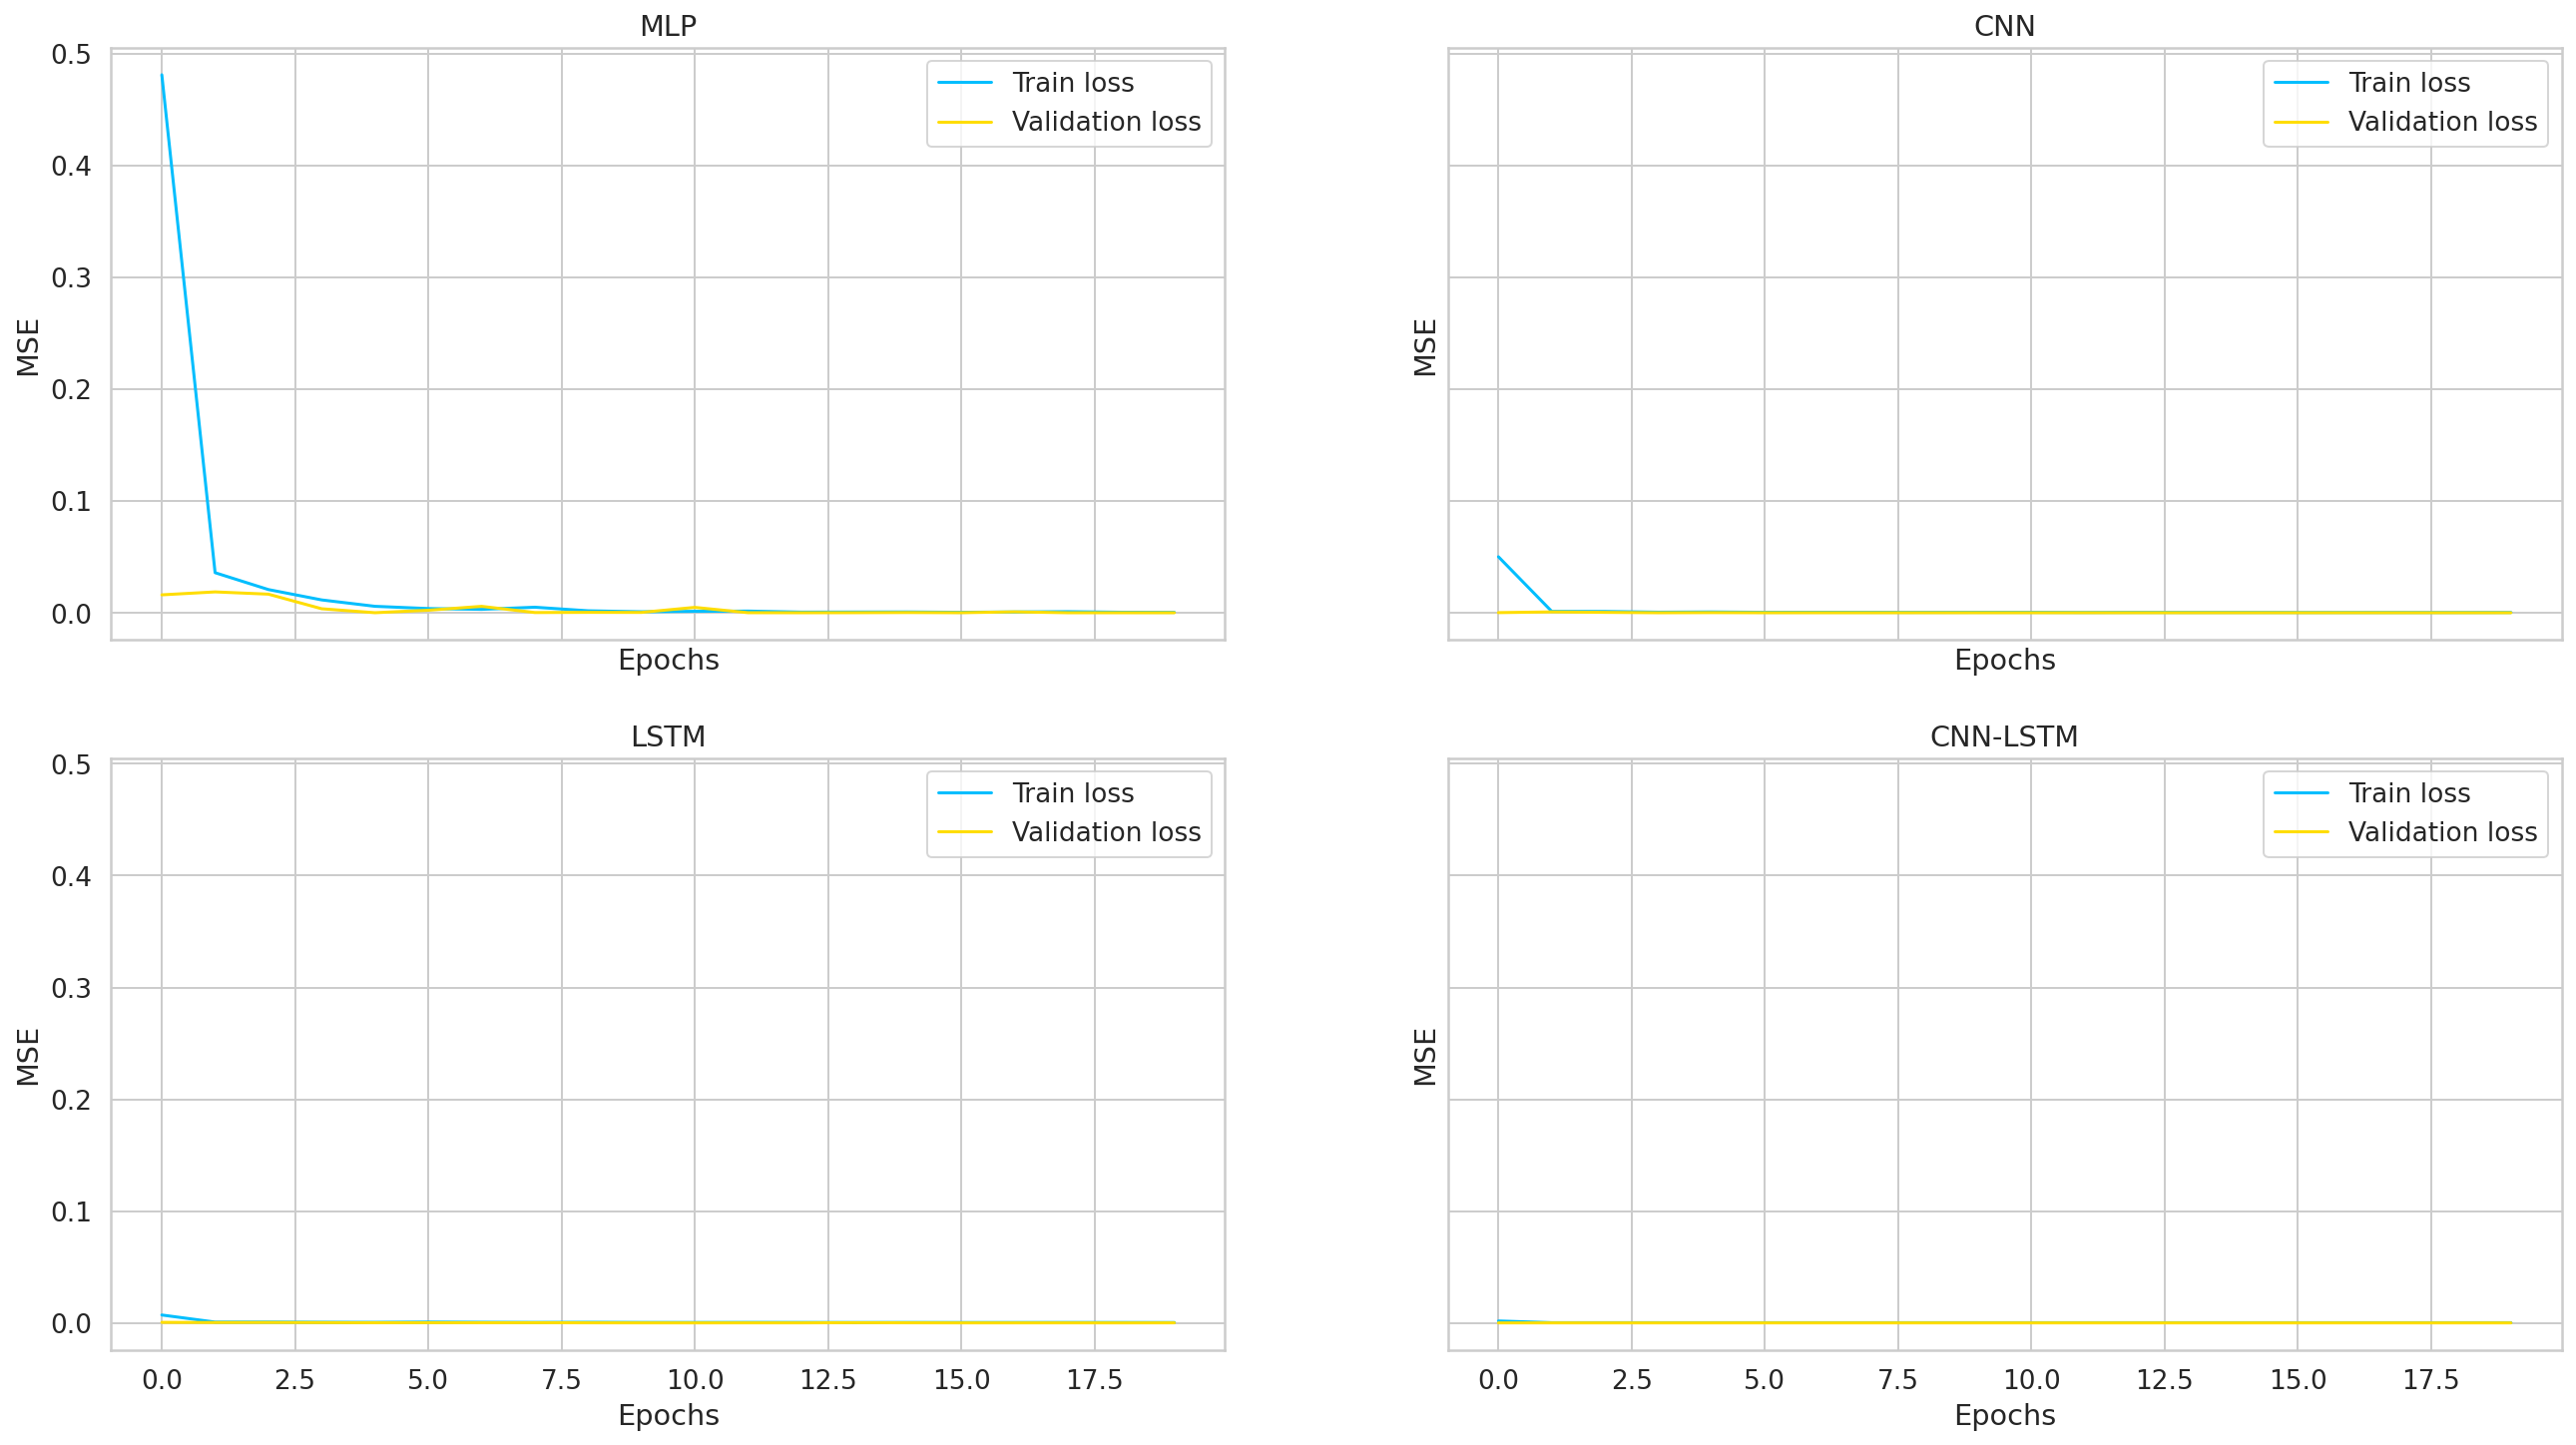

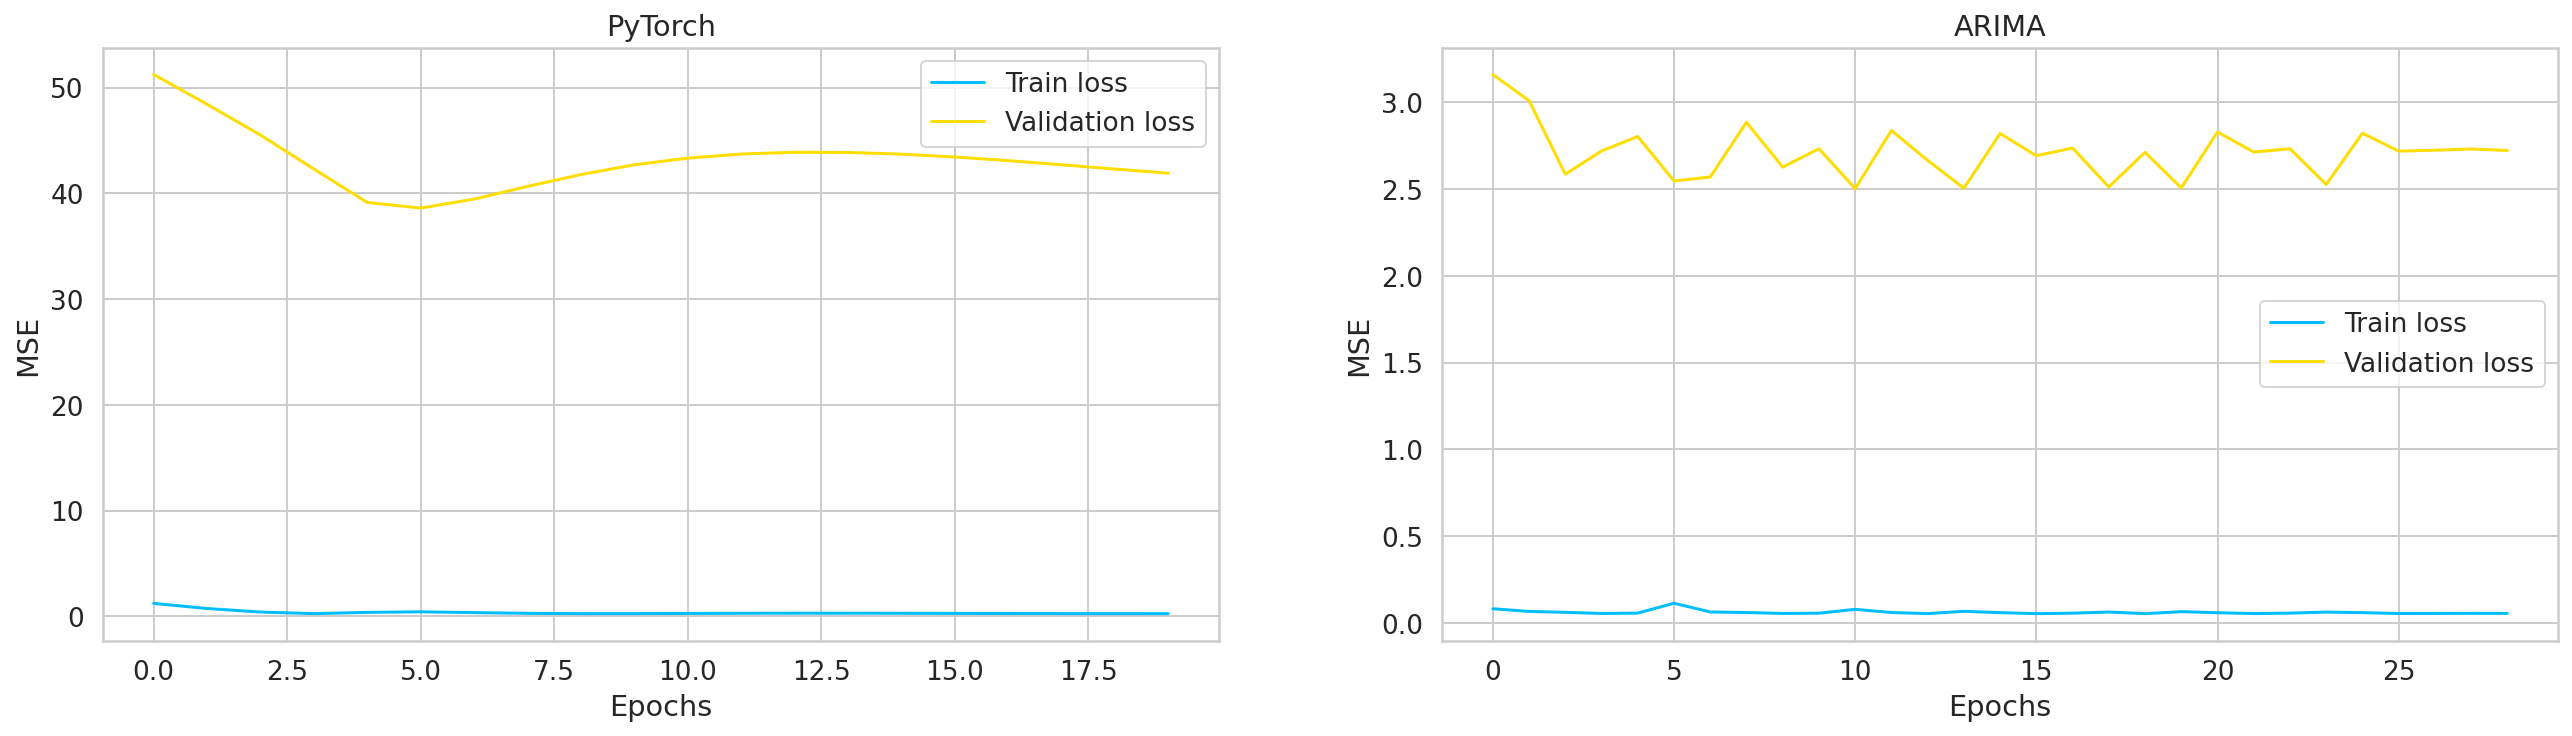

In [58]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

plt.figure(figsize = (22,12))
plt.subplot(2,2,1)
plt.plot(train_hist, label='Train loss')
plt.plot(test_hist, label='Validation loss')
plt.legend(loc='best')
plt.title('PyTorch')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,2)
plt.plot(arima_train_loss, label='Train loss')
plt.plot(arima_valid_loss, label='Validation loss')
plt.legend(loc='best')
plt.title('ARIMA')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.show()

### RMSE

#### MLP

In [59]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 0.01488963592158838
Validation rmse: 0.006744537675711176


#### CNN

In [60]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 0.014652555467590003
Validation rmse: 0.0062367593772055165


#### LSTM

In [61]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 0.01637186362951516
Validation rmse: 0.0062367593772055165


#### CNN - LSTM

In [62]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 0.014526469483850052
Validation rmse: 0.005996374142857966


#### PyTorch

In [63]:
print('Train rmse:', np.sqrt(mean_squared_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0]))))
print('Validation rmse:', np.sqrt(mean_squared_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0]))))

Train rmse: 0.08478568
Validation rmse: 1.2948046


#### ARIMA

In [76]:
train_size = int(len(arima_X_train) * 0.8)
arima_train = arima_X_train[train_size:]
print('Train rmse:', np.sqrt(mean_squared_error(arima_train, arima_train_prediction)))
print('Validation rmse:', np.sqrt(mean_squared_error(arima_X_valid, arima_valid_prediction)))

Train rmse: 0.14053249967472112
Validation rmse: 0.24714301534936914


### Mean Absolute Error

#### MLP

In [77]:
print('Train mae:', mean_absolute_error(Y_train, mlp_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, mlp_valid_pred))

Train mae: 0.002376040590456615
Validation mae: 0.0023447015148569494


#### CNN

In [78]:
print('Train mae:', mean_absolute_error(Y_train, cnn_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, cnn_valid_pred))

Train mae: 0.0017952532963595338
Validation mae: 0.0016735170507585688


#### LSTM

In [79]:
print('Train mae:', mean_absolute_error(Y_train, lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, lstm_valid_pred))

Train mae: 0.007501966822489741
Validation mae: 0.0016735170507585688


#### CNN-LSTM

In [80]:
print('Train mae:', mean_absolute_error(Y_train, cnn_lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, cnn_lstm_valid_pred))

Train mae: 0.0018244589648790167
Validation mae: 0.001607511876477003


#### PyTorch

In [81]:
print('Train mae:', mean_absolute_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0])))
print('Validation mae:', mean_absolute_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0])))

Train mae: 0.049153265
Validation mae: 1.0141432


#### ARIMA

In [82]:
print('Train rmse:', mean_absolute_error(arima_train, arima_train_prediction))
print('Validation rmse:', mean_absolute_error(arima_X_valid, arima_valid_prediction))

Train rmse: 0.08265332109375025
Validation rmse: 0.19360254673895677


### Mean Absolute Percentage Error

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred/y_true)) * 100

#### MLP

In [84]:
print('Train mape:', mean_absolute_percentage_error(Y_train, mlp_train_pred))
print('Validation mape:', mean_absolute_percentage_error(Y_valid, mlp_valid_pred))

Train mape: 252.27840362680055
Validation mape: 258.57937874468547


#### CNN

In [85]:
print('Train mae:', mean_absolute_percentage_error(Y_train, cnn_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, cnn_valid_pred))

Train mae: 251.9943904973089
Validation mae: 237.97147076979343


#### LSTM

In [86]:
print('Train mae:', mean_absolute_percentage_error(Y_train, lstm_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, lstm_valid_pred))

Train mae: 1211.6320907880229
Validation mae: 237.97147076979343


#### CNN-LSTM

In [87]:
print('Train mae:', mean_absolute_percentage_error(Y_train, cnn_lstm_train_pred))
print('Validation mae:', mean_absolute_percentage_error(Y_valid, cnn_lstm_valid_pred))

Train mae: 301.5291538218612
Validation mae: 283.30801619104733


#### PyTorch

In [88]:
print('Train mae:', mean_absolute_percentage_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0])))
print('Validation mae:', mean_absolute_percentage_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0])))

Train mae: 91.2947952747345
Validation mae: 111.68197393417358


#### ARIMA

In [89]:
print('Train mae:', mean_absolute_percentage_error(arima_X_train, arima_train_prediction))
print('Validation mae:', mean_absolute_percentage_error(arima_X_valid, arima_valid_prediction))

Train rmse: 185.37371566351013
Validation rmse: 112.32278031693839


### MSE

#### MLP

In [90]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train mse:', (mean_squared_error(Y_train, mlp_train_pred)))
print('Validation mse:', (mean_squared_error(Y_valid, mlp_valid_pred)))

Train mse: 0.00022170125787745508
Validation mse: 4.548878845908752e-05


#### CNN

In [91]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train mse:', (mean_squared_error(Y_train, cnn_train_pred)))
print('Validation mse:', (mean_squared_error(Y_valid, cnn_valid_pred)))

Train mse: 0.00021469738173080167
Validation mse: 3.889716752916094e-05


#### LSTM

In [92]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train mse:', (mean_squared_error(Y_train, lstm_train_pred)))
print('Validation mse:', (mean_squared_error(Y_valid, lstm_valid_pred)))

Train mse: 0.0002680379187034413
Validation mse: 3.889716752916094e-05


#### CNN - LSTM

In [93]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train mse:', (mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation mse:', (mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train mse: 0.0002110183156652268
Validation mse: 3.595650286113561e-05


#### PyTorch

In [94]:
print('Train mse:', (mean_squared_error(np.array(y_train_torch.detach()).reshape(y_train_torch.shape[0]), np.array(y_pred.detach()).reshape(y_pred.shape[0]))))
print('Validation mse:', (mean_squared_error(np.array(y_valid_torch.detach()).reshape(y_valid_torch.shape[0]), np.array(y_test_pred.detach()).reshape(y_test_pred.shape[0]))))

Train mse: 0.0071886107
Validation mse: 1.6765189


#### ARIMA

In [96]:
print('Train mse:', (mean_squared_error(arima_train, arima_train_prediction)))
print('Validation mse:', (mean_squared_error(arima_X_valid, arima_valid_prediction)))

Train mse: 0.01974938346482549
Validation mse: 0.061079670035978514
